# Problem Sheet: Convolution and Deblurring

## Objectives
- Implement 1D/2D convolution with different boundary conditions
- Understand kernel effects on signals/images
- Implement deblurring via inverse Fourier transform and observe effect of different noise

---

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from skimage import data

# Exercise 1: 1D Convolution
For discrete signals $f$ and $g$, convolution $(f * g)[n]$ is defined as:

$$
(f * g)[n] = \sum_{m=-\infty}^{\infty} f[m] \cdot g[n - m]
$$

## 1. Zero-Padded Convolution
### Definition
For a signal `x[n]` of length `N` and kernel `h[m]` of length `M`:

$$
(x *_{\text{zero}} h)[n] = \sum_{m=0}^{M-1} h[m] \cdot \tilde{x}[n - m]
$$

where the padded signal $\tilde{x}[k]$ is:

$$
\tilde{x}[k] = 
\begin{cases} 
x[k] & \text{if } 0 \leq k < N \\
0 & \text{otherwise}
\end{cases}
$$

### Properties
- **Output length**: $N$ (same-mode; we implement this one) or $N + M - 1$ (full).
- **Edge behavior**: Introduces artificial zeros at boundaries  
- **Best for**: Non-periodic signals (e.g., natural images, sensor data)

## 2. Cyclic (Periodic) Convolution

### Definition
For a discrete signal $x[n]$ of length $N$ and kernel $h[m]$ of length $M$:

$$
(x *_{\text{cyclic}} h)[n] = \sum_{m=0}^{M-1} h[m] \cdot x[(n - m) \mod N]
$$

where:
- $x[k \mod N]$ enforces periodicity (e.g., $x[-1] = x[N-1]$)
- Output length is exactly $N$ (same as input)

## Key Properties
| Property          | Description |
|-------------------|-------------|
| **Periodicity**   | Treats signal as infinitely repeating: $x[n] = x[n \mod N]$ |
| **Edge Handling** | Wraps around boundaries (no discontinuities) |
| **FFT Relation**  | Equivalent to pointwise multiplication in Fourier domain: $\mathcal{F}(x *_{\text{cyclic}} h) = \mathcal{F}(x) \cdot \mathcal{F}(h)$ |
| **Artifacts**     | May create false correlations between opposite ends of the signal |



## Task
- Implement the `convolve_1d()` function that suppords 1D convolution with different boundary conditions
- Plot the convolution for a given rectangular pulse with a Gaussian Kernel with zero-padded vs. cyclic boundary condition.
- For what kind of signal would the boundary condition affect the result of the convolution?

Below you are given some starter code.



Text(0.5, 1.0, 'Gaussian Kernel')

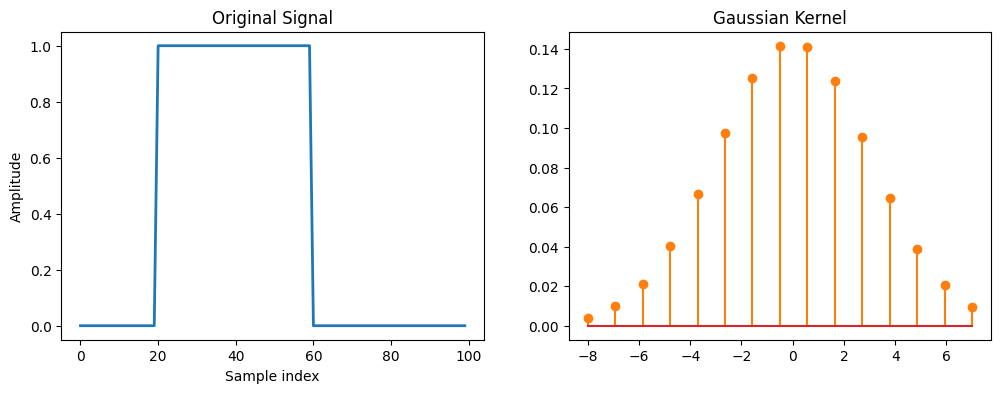

In [2]:
def convolve_1d(signal, kernel, mode='zero-pad'):
    """
    Args:
        signal: 1D input array
        kernel: 1D convolution kernel
        mode: 'zero-pad' or 'cyclic'
    
    Returns:
        Convolved signal (same length as input)
    """
    # Your implementation here
    # Hint: use np.pad with mode 'wrap' or 'constant'
    
# Signal: rectangular pulse
signal = np.zeros(100)
signal[20:60] = 1.0 

# Kernel setup
kernel_size = 15
sigma = 3.0
positions = np.linspace(-kernel_size//2, kernel_size//2, kernel_size)
kernel = np.exp(-positions**2 / (2 * sigma**2))
kernel /= np.sum(kernel)

# Plotting 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot original signal
ax1.plot(signal, linewidth=2)
ax1.set_title("Original Signal")
ax1.set_xlabel("Sample index")
ax1.set_ylabel("Amplitude")

# Plot kernel
ax2.stem(positions, kernel, linefmt='C1-', markerfmt='C1o')
ax2.set_title("Gaussian Kernel")

## Solution

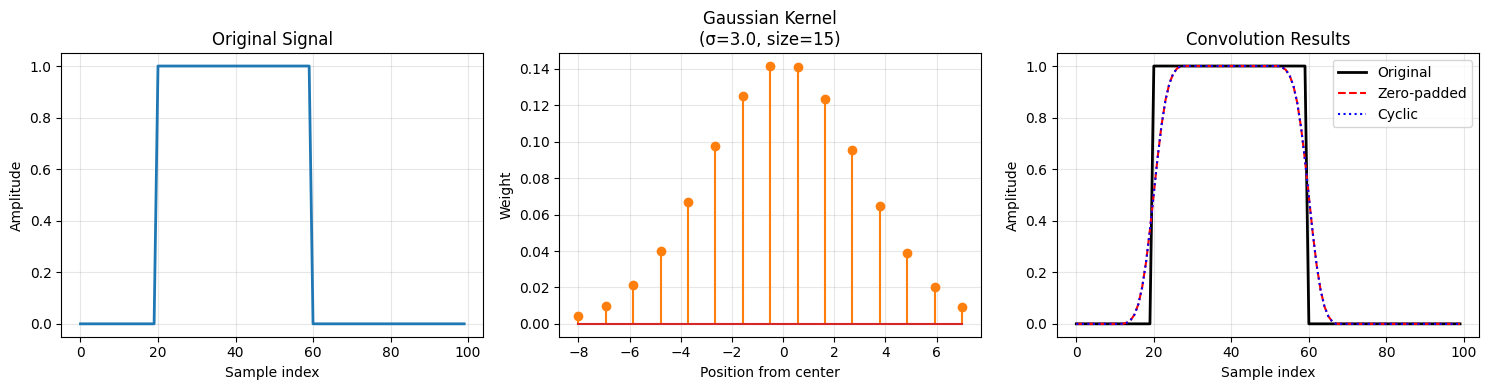

In [3]:
def convolve_1d(signal, kernel, mode='zero-pad'):
    """Compute 1D convolution with specified boundary handling.
    
    Args:
        signal: Input 1D array
        kernel: Convolution kernel array
        mode: Boundary mode ('zero-pad' or 'cyclic')
    
    Returns:
        Convolved signal (same length as input)
    
    Raises:
        ValueError: If mode is not 'zero-pad' or 'cyclic'
    """
    signal_len = len(signal)
    kernel_len = len(kernel)
    output = np.zeros(signal_len)
    pad_width = kernel_len // 2  # Center kernel
    
    # Handle boundary conditions
    if mode == 'zero-pad':
        padded_signal = np.pad(signal, pad_width, mode='constant')
    elif mode == 'cyclic':
        padded_signal = np.pad(signal, pad_width, mode='wrap')
    else:
        raise ValueError("Mode must be either 'zero-pad' or 'cyclic'")

    # Flip kernel for proper convolution operation
    flipped_kernel = kernel[::-1]
    
    # Perform convolution
    for i in range(signal_len):
        output[i] = np.sum(padded_signal[i:i+kernel_len] * flipped_kernel)
    
    return output

# Create test signal (rectangular pulse)
signal = np.zeros(100)
signal[20:60] = 1.0 

# Generate normalized Gaussian kernel
kernel_size = 15
sigma = 3.0
positions = np.linspace(-kernel_size//2, kernel_size//2, kernel_size)
kernel = np.exp(-positions**2 / (2 * sigma**2))
kernel /= np.sum(kernel)  # Normalize to sum=1

# Compute convolutions
conv_zero_pad = convolve_1d(signal, kernel, mode='zero-pad')
conv_cyclic = convolve_1d(signal, kernel, mode='cyclic')

# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot original signal
ax1.plot(signal, linewidth=2)
ax1.set_title("Original Signal")
ax1.set_xlabel("Sample index")
ax1.set_ylabel("Amplitude")
ax1.grid(True, alpha=0.3)

# Plot kernel using stem plot
ax2.stem(positions, kernel, linefmt='C1-', markerfmt='C1o')
ax2.set_title(f"Gaussian Kernel\n(σ={sigma}, size={kernel_size})")
ax2.set_xlabel("Position from center")
ax2.set_ylabel("Weight")
ax2.grid(True, alpha=0.3)

# Plot convolution results
ax3.plot(signal, 'k-', label="Original", linewidth=2)
ax3.plot(conv_zero_pad, 'r--', label="Zero-padded")
ax3.plot(conv_cyclic, 'b:', label="Cyclic")
ax3.set_title("Convolution Results")
ax3.set_xlabel("Sample index")
ax3.set_ylabel("Amplitude")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Exercise 2: 2D Convolution with Different Kernels
For images $I$ and kernel $K$:

$$
(I * K)[x,y] = \sum_{i=-\infty}^{\infty} \sum_{j=-\infty}^{\infty} I[i,j] \cdot K[x-i, y-j]
$$

## Tasks
- Implement `convolve_2d()` with zero-padded boundaries.
- Compute convolution of the Camera-Man-Image with the following 2d kernels:
    - (a) Gaussian Kernel
    - (b) X-Derivative Kernel
    - (c) Y-derivative
    - (d) Laplacian Kernel
- Visualize the kernels under the convolutions
- Understand effects of different kernel types. What does the Gaussian Kernel do? What does the Laplacian kernel do? 

Below is a starter code.

## Solution

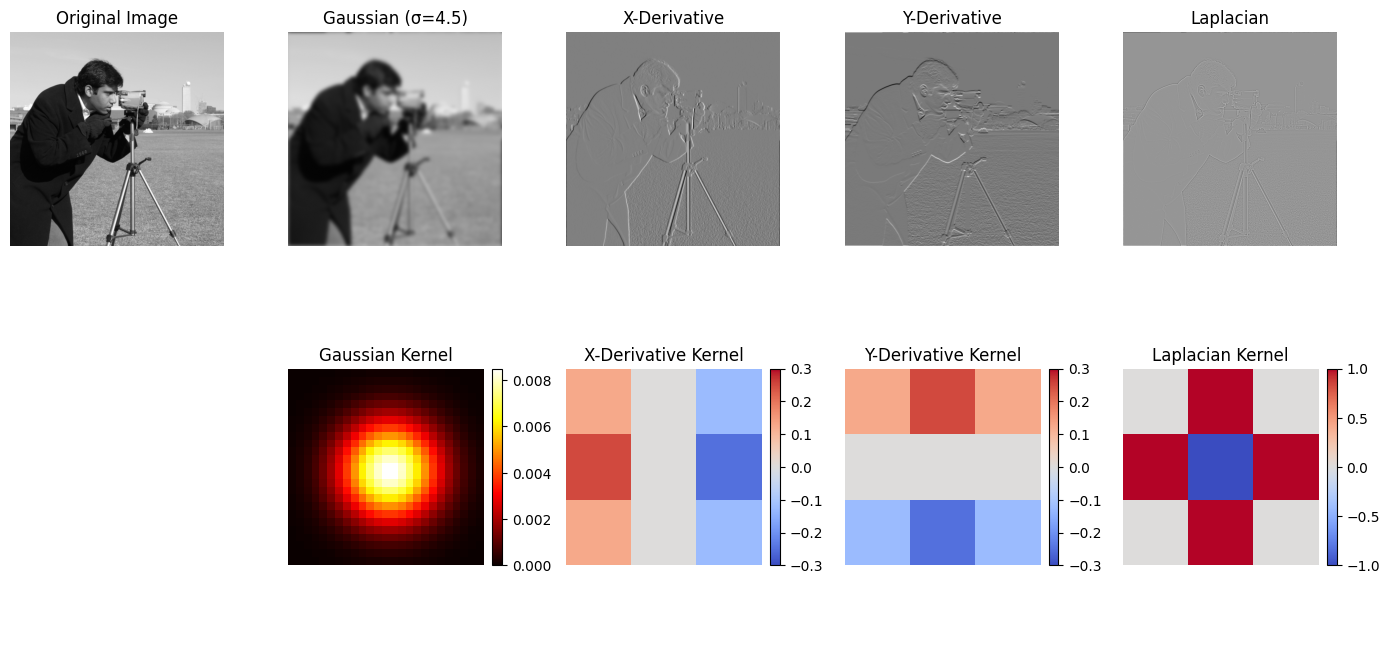

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

def convolve_2d(image, kernel):
    """2D convolution with periodic boundary conditions"""
    ih, iw = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh//2, kw//2
    
    # Create padded image with periodic boundaries
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='wrap')
    
    # Flip kernel for correlation (convolution)
    kernel = np.flipud(np.fliplr(kernel))
    
    output = np.zeros_like(image)
    for i in range(ih):
        for j in range(iw):
            output[i,j] = np.sum(padded[i:i+kh, j:j+kw] * kernel)
    return output

# Kernel definitions with adjustable blur scale
def gaussian_kernel(size=5, sigma=1.0):
    """Sigma controls blur amount - larger sigma = more blur"""
    x = np.linspace(-size//2, size//2, size)
    x, y = np.meshgrid(x, x)
    kernel = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return kernel / np.sum(kernel)

def derivative_x_kernel():
    return np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]]) / 8

def derivative_y_kernel():
    return np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]]) / 8

def laplacian_kernel():
    return np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

# Parameters
sigma = 4.5  # Adjust blur amount here!

# Load image of camera man
image = data.camera().astype(float)/255
kernels = {
    'Gaussian (σ={})'.format(sigma): gaussian_kernel(size=25, sigma=sigma),
    'X-Derivative': derivative_x_kernel(),
    'Y-Derivative': derivative_y_kernel(),
    'Laplacian': laplacian_kernel()
}

# Create figure
plt.figure(figsize=(14, 7))

# First row: Original + Convolution Results
plt.subplot(2, 5, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

for i, (name, kernel) in enumerate(kernels.items(), start=2):
    result = convolve_2d(image, kernel)
    if name.startswith('Gaussian'):
        # No normalization for Gaussian
        vmin, vmax = 0, 1
    else:
        # Normalize derivatives/Laplacian
        result = (result - result.min()) / (result.max() - result.min())
        vmin, vmax = 0, 1
    
    plt.subplot(2, 5, i)
    plt.imshow(result, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title(name)
    plt.axis('off')

# Second row: Empty + Kernels
plt.subplot(2, 5, 6)  # Empty cell
plt.axis('off')

# Individual scaling for each kernel's heatmap
kernel_scales = {
    'Gaussian': (0, None),  # Auto-scale
    'X-Derivative': (-0.3, 0.3),
    'Y-Derivative': (-0.3, 0.3),
    'Laplacian': (-1, 1)
}

for i, (name, kernel) in enumerate(kernels.items(), start=7):
    plt.subplot(2, 5, i)
    vmin, vmax = kernel_scales[name.split()[0]]  # Get scale by kernel type
    
    # Use 'hot' colormap for positive-only, 'coolwarm' for signed kernels
    cmap = 'hot' if name.startswith('Gaussian') else 'coolwarm'
    im = plt.imshow(kernel, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title("{} Kernel".format(name.split(' (')[0]))
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Exercise 3: Image Deblurring via Fourier Methods

## Background

We consider the image formation model:

$$ B = I * K + \eta $$

where:
- $I$ is the true image (unknown)
- $K$ is the blur kernel (known Point Spread Function)
- $\eta$ is additive noise
- $B$ is the observed blurred image

For periodic boundary conditions, the convolution theorem gives:

$ \mathcal{F}\{I*K\} = \mathcal{F}\{I\} \cdot \mathcal{F}\{K\}$

where $\mathcal{F}$ denotes the 2D Fourier transform. If the noise is zero, we can deblur the image as

$I = \mathcal{F}^{-1}\{\frac{\mathcal{F}\{B\}}{\mathcal{F}\{K\}}\}$

## Task

Implement the Fourier deconvolution approach and apply it to a blurred image with (a) zero-noise, (b) Gaussian-noise, (c) scaled high-frequency sine-wave-noise. What do you observe? Why does this deblurring approach fail catastrophically even with relatively small noise?

# Solution

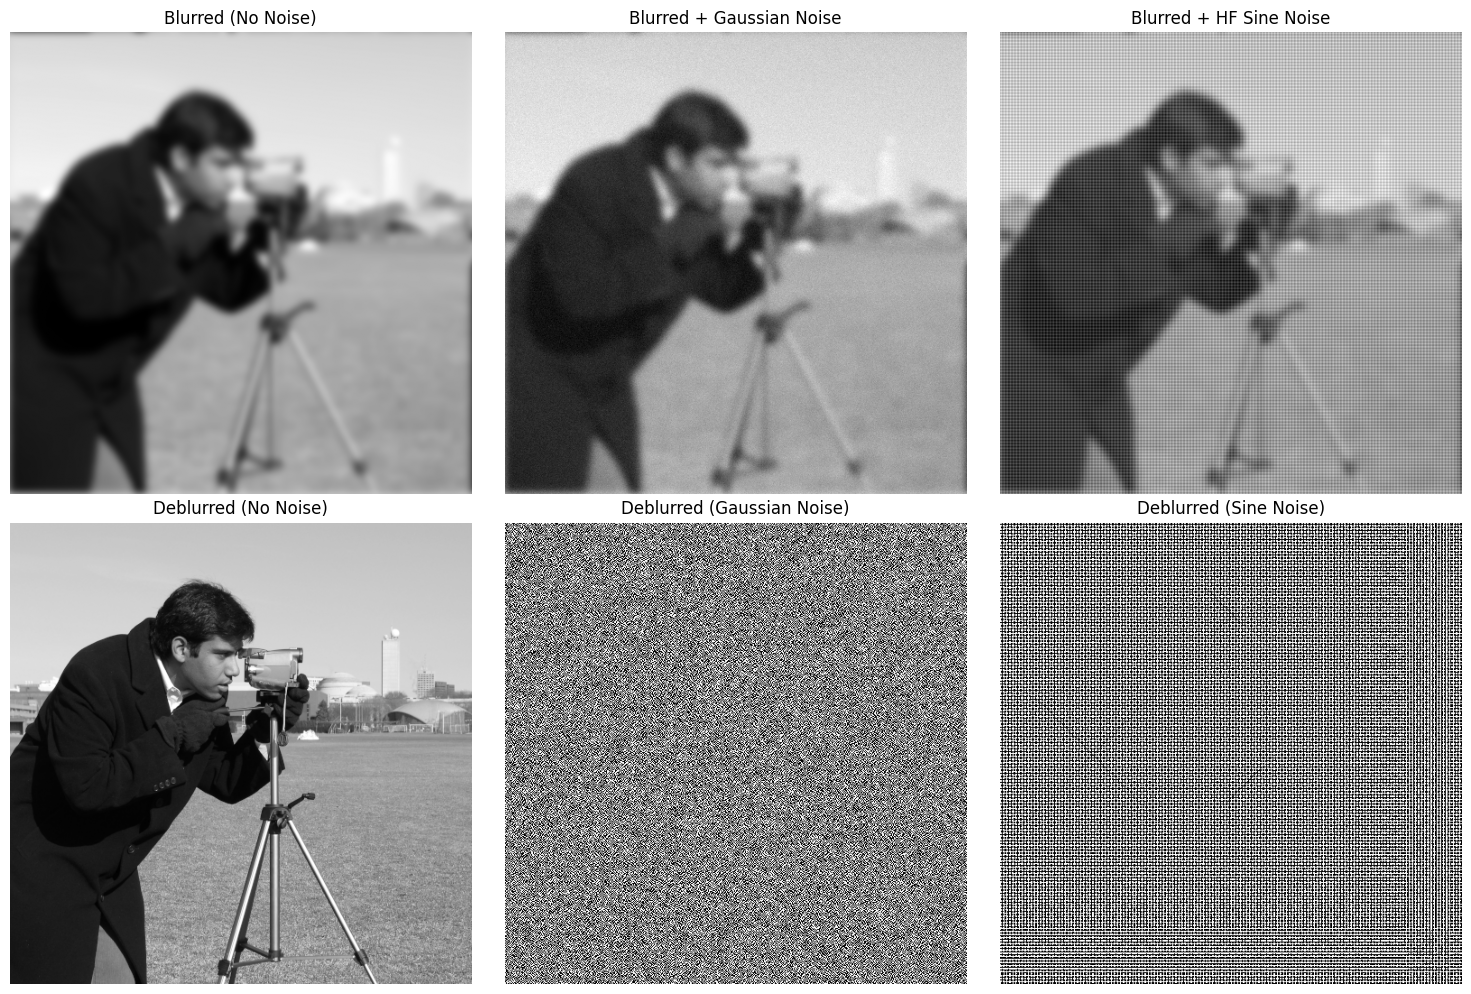

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from scipy.fft import fft2, ifft2, fftshift, ifftshift

def gaussian_kernel(size=25, sigma=4.5):
    """Generate 2D Gaussian kernel"""
    x = np.linspace(-size//2, size//2, size)
    x, y = np.meshgrid(x, x)
    kernel = np.exp(-(x**2 + y**2)/(2*sigma**2))
    return kernel / np.sum(kernel)

def blur_image_fourier(image, kernel):
    """Blur image using Fourier convolution theorem"""
    # Pad kernel to match image size
    kernel_padded = np.zeros_like(image)
    kh, kw = kernel.shape
    ih, iw = image.shape
    
    # Center the kernel in the padded array
    start_h, start_w = (ih - kh) // 2, (iw - kw) // 2
    kernel_padded[start_h:start_h+kh, start_w:start_w+kw] = kernel
    
    # Fourier transforms
    image_fft = fft2(image)
    kernel_fft = fft2(ifftshift(kernel_padded))  # Center the kernel in Fourier space
    
    # Convolution in spatial domain = multiplication in Fourier domain
    blurred_fft = image_fft * kernel_fft
    blurred = np.real(ifft2(blurred_fft))
    
    return blurred

def deblur_image_fourier(blurred, kernel, epsilon=1e-9):
    """Deblur image using inverse filtering in Fourier domain"""
    # Pad kernel to match image size
    kernel_padded = np.zeros_like(blurred)
    kh, kw = kernel.shape
    ih, iw = blurred.shape
    
    # Center the kernel in the padded array
    start_h, start_w = (ih - kh) // 2, (iw - kw) // 2
    kernel_padded[start_h:start_h+kh, start_w:start_w+kw] = kernel
    
    # Fourier transforms
    blurred_fft = fft2(blurred)
    kernel_fft = fft2(ifftshift(kernel_padded))  # Center the kernel
    
    # Inverse filtering with stability parameter epsilon to avoid division by zero
    deblurred_fft = blurred_fft / (kernel_fft + epsilon)
    deblurred = np.real(ifft2(deblurred_fft))
    
    return deblurred

# Load and prepare image
image = img_as_float(data.camera())
kernel = gaussian_kernel(size=25, sigma=4.5)

# Blur the image
blurred = blur_image_fourier(image, kernel)

# Create different noise cases
noise_gaussian = np.random.normal(0, 0.02, image.shape)
x = np.linspace(0, 20*np.pi, image.shape[1])
y = np.linspace(0, 20*np.pi, image.shape[0])
X, Y = np.meshgrid(x, y)
noise_sine = 0.1 * (np.sin(15*X) + np.sin(15*Y))

# Create noisy versions
blurred_gauss = blurred + noise_gaussian
blurred_sine = blurred + noise_sine

# Deblur all cases with tight regularization
epsilon = 1e-9
deblurred_clean = deblur_image_fourier(blurred, kernel, epsilon)
deblurred_gauss = deblur_image_fourier(blurred_gauss, kernel, epsilon)
deblurred_sine = deblur_image_fourier(blurred_sine, kernel, epsilon)

# Plot results in 2x3 grid
plt.figure(figsize=(15, 10))

# Top row: Noisy images
plt.subplot(2, 3, 1)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred (No Noise)')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(blurred_gauss, cmap='gray')
plt.title('Blurred + Gaussian Noise')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(blurred_sine, cmap='gray')
plt.title('Blurred + HF Sine Noise')
plt.axis('off')

# Bottom row: Deblurred results
plt.subplot(2, 3, 4)
plt.imshow(deblurred_clean, cmap='gray', vmin=0, vmax=1)
plt.title('Deblurred (No Noise)')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(deblurred_gauss, cmap='gray', vmin=0, vmax=1)
plt.title('Deblurred (Gaussian Noise)')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(deblurred_sine, cmap='gray', vmin=0, vmax=1)
plt.title('Deblurred (Sine Noise)')
plt.axis('off')

plt.tight_layout()
plt.show()